# Computational assignment 1: baseball and golf

Participants: Andreas Nossum & Ingve Aleksander Hetland

This computational assignment is part of the course TFY4345 and will analyze different aspects of projectile motion in the sports baseball and golf. Firstly we will calculate a batted baseballs trajectory as it flies away, and see how drag force and rotation will affect it. Secondly, we will turn our attention to golf where we explore the effects of surface attributes and spin in different directions. We import necessary libraries.

In [1]:
from mpl_toolkits import mplot3d

%matplotlib inline
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import math

newparams = {'figure.figsize': (10, 6), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

Before we can calculate any trajectory, we will have to create a vector containing all quantities of interest, and which will be extremely useful when we apply ODE-solvers later on. This function is here called $\vec{\omega}$ and has the form

$$
\vec{\omega} = \begin{bmatrix}\ x \\ y \\ z \\ v_{x} \\ v_{y} \\ v_{z} \\ \beta \end{bmatrix}
$$

For our ODE-solver to work, we need to find the derivative of this which is given by $\vec{f} = \frac{d}{dt}\vec{\omega}$

$$
\frac{d}{dt} \vec{\omega} = \frac{d}{dt} \begin{bmatrix}\ x \\ y \\ z \\ v_{x} \\ v_{y} \\ v_{z} \\ \beta \end{bmatrix} = \begin{bmatrix}\ v_{x} \\ v_{y} \\ v_z \\ a_x \\ a_y \\ a_z \\ \omega \end{bmatrix} = \vec{f}
$$


Here, it is important to distinguish between $\vec{\omega}$, the vector containing quantities of interest, and $\omega = \frac{d}{dt}\beta$, which denotes angular frequency of the ball. We choose to define the function `omega()` which takes in values for the quantities we are interested in, and returns a numpy array containing these values, functioning as our $\vec{\omega}$. This function is made general such that it can be used for all tasks. If a task does not include one of the quantities, the quantity and its corresponding EOM is simply set to zero in both $\vec{\omega}$ and $\vec{f}$.

In [2]:
# Function containing quantities of interest
def omega(x, y, z, vx, vy, vz, theta):
    """
    INPUT:
    x:     float,     x-coordinate
    y:     float,     y-coordinate
    z:     float,     z-coordinate
    vx:    float,     x-component of velocity
    vy:    float,     y-component of velocity
    vz:    float,     z-component of velocity
    theta: float,     Angular orientation of the ball
    ---
    Returns a one-dimensional array with the quantities of interest for solving the equations of motion
    """
    return np.array([x,
                     y,
                     z,
                     vx,
                     vy,
                     vz,
                     theta], dtype="float64")

For this assignment we have chosen a Runge Kutta 4th order ODE-solver which will take in our EOM and calculate the next step in the projectile 
motion, and thereby making is possible to see exactly where the ball would be at a given time. It will also include a part to check whether it has touched the ground, and how far away from the home plate it is at that time. We therefore define a function `RK4()` which performs one iteration of the numerical method, and another function `ode_solver()` which solves our EOM until the ball has hit the ground and stores the position, velocity and time values, such that they can be returned and plotted after the simulation. The function also detects if the ball has hit the ground by checking if its $y$-coordinate is less than zero. If $y<0$, we perform linear interpolation to locate the $x$- and $z$-coordinate when $y$ would equal $0$. This looks as such:

$$
x_l = \frac{x_n + rx_{n+1}}{r + 1}, r = -\frac{y_n}{y_{n+1}}
$$

Where $n+1$ corresponds to the last coordinate. The same is done for the $z$-coordinate by inserting $z$-values instead of the $x$-values; $y$-values remain the same. This is done because the solution is very unlikely to encounter the exact landing position by itself, meaning it must be calculated.

In [3]:
def RK4(f, t, w, h):
    """
    INPUT:
        f:         funksjon,     Vector of equations, w'(t) = f(t, w)
        t:         float,        Time at calculation
        w:         1D array,     Function containing quantities of interest
        h:         float,        Step length
    ---
    Performs one step of the classic Runge-Kutta 4 method for solving ODEs
    ---
    OUTPUT:
        t_next:    float,        Next time in calculation
        w_next:    1D array,     New values for functions in w
    """
    k1 = f(t, w)
    k2 = f(t + h/2, w + h*k1/2)
    k3 = f(t + h/2, w + h*k2/2)
    k4 = f(t + h, w + h*k3)

    t_next = t + h
    w_next = w + h*(k1/6 + k2/3 + k3/3 + k4/6)
    return t_next, w_next

# Function for solving ODEs
def ode_solver(f, omega, r0, v0, theta0, method=RK4):
    """
    INPUT:
    f:         Function,     Returns 1D array with right hand side of 1st order representation of equations of motion
    omega:     Function,     Returns 1D array with left hand side of 1st order representation of equations of motion, quantities of interest
    r0:        1D array,     Initial position of form [x, y, z]
    v0:        1D array,     Initial velocity of form [vx, vy, vz]
    theta0:    float,        Initial angular orientation of ball
    method:    Function,     Performs one step of numerical method and returns updated quantities, we only use RK4
    ---
    Solves the equations of motion given by f and quantities of interest numerically until ball is detected underground,
    while constructing arrays for position, velocity and time. Also uses interpolation to calculate exact position where
    the ball hits the ground.
    ---
    OUTPUT:
    r:        2D array,     Array of position vectors for every time-step
    v:        2D array,     Array of velocity vectors for every time-step
    time:     1D array,     Array with every time-step
    rl:       1D array,     Position vector when ball hits the ground
    """
    
    r = np.array([r0])                # Array with positions [x, y, z], will fill up as projectile moves
    v = np.array([v0])                # Array with corresponding velocities in each direction [x, y, z]

    w = omega(r0[0], r0[1], r0[2], v0[0], v0[1], v0[2], theta0)     #Construct vector with initial values for left hand side of EOM
    h = 0.01                          # Step length
    t = 0                             # Time of batting
    time = np.array([t])
    
    # Iterate while ball is above or at ground level
    while w[1] > 0:
        t, w = method(f, t, w, h)     # Using method of choice to calculate next configuration of place and velocity

        # Arrays with next position/velocity respectively for each step 
        rnext = np.array([w[:3]])
        vnext = np.array([w[3:-1]])
        
        # Storing each position, velocity and time to corresponding main array for each step
        r = np.concatenate((r, rnext), axis=0)
        v = np.concatenate((v, vnext), axis=0)
        time = np.append(time, t)

    # Calculating where the ball has reached the ground by linear interpolation
    q = - r[-2, 1]/r[-1, 1]
    xl = (r[-2, 0] + q*r[-1, 0])/(q + 1)
    zl = (r[-2, 2] + q*r[-1, 2])/(q + 1)
    
    rl = np.array([xl, 0, zl])         # Final position vector
    r[-1] = rl                         # Add final position vector to main array

    return r, v, time, rl

## Baseball


One key factor in the EOM, in the cases of baseball, is drag. Studies in wind tunnels show that the drag force, here in the $x$-direction, is given by

$$
F_{drag,x} = -B_{2} |v - v_{wind}|(v_{x}-v_{wind})
$$

where

$$
\frac{B_2}{m} = 0.0039 + \frac{0.0058}{1 + \exp{\left(\frac{|v - v_{wind}| - v_d}{\Delta}\right)}}
$$

In our calculations, $v_d = 35\text{ m/s and }\Delta = 5 \text{ m/s}$ are used. Since $B_2$ depends on speed, it is beneficial to define a function `B2()` for calculating this factor, such that we easily can calculate it for every step of our numerical solutions.

In [4]:
# Drag force based on wind tunnel experiments
def B2(v):
    """
    INPUT:
    v:     float,     Speed of the object's center of mass, [m/s]
    ---
    Returns the parameter B_2 which is used to calculate the drag force on the baseball
    """
    return m*(0.0039 + 0.0058/(1 + math.exp((norm(v - vwind) - vd)/delta)))

### Batted ball

Our first goal is to see how forces of drag from wind will affect the trajectory of a baseball. We are currently operating in two dimensions, so the quantities dependent on $z$ are put to $0$ as of now.

The components of $\vec{\omega}$, and thereby $\vec{f}$, will change later on, but the main idea is the same for all projectile motion. For this task we are neglecting the drag force in the $y$-direction. The resulting EOM is given by the vector equation:

$$
\frac{d}{dt}\vec{\omega} =  \vec{f} \\
\frac{d}{dt}\begin{bmatrix}\ x \\ y \\ z \\ v_{x} \\ v_{y} \\ v_{z} \\ \beta \end{bmatrix} = \begin{bmatrix}\ v_x \\ v_y \\ 0 \\ -\frac{B_2|v-v_{wind}|\left(v-v_{wind}\right)}{m} \\ -g \\ 0 \\ 0 \end{bmatrix}
$$

We incorporate the right hand side of this equation as the function `EOM_1a()`. We also define parameters $m$, $v_d$, $\Delta$ and $g$ as these will stay constant throughout task 1.

In [5]:
m = 0.149          # Mass of baseball, [kg]
vd = 35            # Velocity parameter for drag, [m/s]
delta = 5          # Parameter in drag calculation, [m/s]
g = 9.81           # Gravitational acceleration, [m/s^2]

# Equations of motion as a function of w
def EOM_1a(t, w):
    """
    INPUT:
    t:     float,     Current time in calculations
    w:     1D array,  Array with quantities of interest, corresponds to left side of 1st order representation of equations of motion
    ---
    Returns a 1D array with the right hand side of the 1st order representation of equations of motion
    """
    return np.array([w[3],
                     w[4],
                     0,
                     -(B2(w[3:-1])*norm(w[3:-1] - vwind)*(w[3] - vwind[0]))/m,
                     -g,
                     0,
                     0], dtype="float64")

The crowd settles down as the game is about to start. The pitcher holds the ball in a firm grip as the experienced batter gets into position right next to the home plate. His mind is set - he will hit the ball straight down the middle of the playing field as far as it goes (therefore no $z$-component yet). Our EOM and ODE-solver are now at standby, ready to be used when the pitcher throws the ball into action. The whistle is heard, and away we go! A white and striped ball comes shooting towards the determined hitter. A recognizable sound is heard when the ball makes contact with the wooden bat and ... stop. Freeze frame. Let us take a step back and use the power of numerical calculation to analyze how the next couple of seconds could unfold.

The practiced batter has had his fair share of training hours, to say the least, and we will therefore assume that he can hit the ball with an exit speed of $50$ m/s. But how exactly should he hit the ball, other than with raw power? And how should he adapt the exit angle given different weather conditions, mainly wind? This is the kind of questions one does not have time for when the ball flashes towards you, but something we can examine from the safeness behind a computer screen. We will therefore look at three different wind conditions, and calculate the optimal batting angle given the circumstances.

In [6]:
v0 = 50                         # Initial velocity, [m/s]
phi0 = math.radians(0)          # Initial angle in xz-plane (will be zero when we only look at xy-plane), [rad]
theta = np.arange(math.radians(1), np.pi/2, math.radians(1))     # Array with initial angles in xy-plane

r0 = np.array([0, 1, 0])        # Initial position, m

vwind_tail = 10                 # Positive, m/s
vwind_head = -10                # Negative, m/s
vwind_zero = 0                  # No wind, m/s

In [7]:
# ZERO WIND
vwind = np.array([vwind_zero, 0, 0])      # Array with velocity of wind in each direction [x, y, z]

xl_array_nowind = np.zeros(len(theta))    # Initialize array for values for distance travelled

for i, vals in enumerate(theta):

    vx0 = v0*np.cos(vals)    # x-component of initial velocity, [m/s]
    vy0 = v0*np.sin(vals)    # y-component of initial velocity, [m/s]
    vz0 = 0                  # z-component of initial velocity, [m/s]
    v0_array = np.array([vx0, vy0, vz0])  # Array with initial velocities in each direction [x, y, z]
    
    # Run simulation
    r_nowind, v_nowind, t_nowind, rl_nowind = ode_solver(EOM_1a, omega, r0, v0_array, 0)
    
    # Store value for distance travelled in array
    xl_array_nowind[i] = rl_nowind[0]

max_nowind = np.amax(xl_array_nowind)                                                 # Identify the the largest value for distance travelled
optimal_nowind = np.degrees(theta[np.where(xl_array_nowind == max_nowind)[0][0]])     # Identify initial angle yielding furthest distance travelled

In [8]:
# HEADWIND
vwind = np.array([vwind_head, 0, 0])      # Array with velocity of wind in each direction [x, y, z]

xl_array_head = np.zeros(len(theta))      # Initialize array for values for distance travelled

for i, vals in enumerate(theta):
    vx0 = v0*np.cos(vals)    # x-component of initial velocity, [m/s]
    vy0 = v0*np.sin(vals)    # y-component of initial velocity, [m/s]
    vz0 = 0                  # z-component of initial velocity, [m/s]
    v0_array = np.array([vx0, vy0, vz0])  # Array with initial velocities in each direction [x, y, z]

    # Run simulation
    r_head, v_head, t_head, rl_head = ode_solver(EOM_1a, omega, r0, v0_array, 0)
    
    # Store value for distance travelled in array
    xl_array_head[i] = rl_head[0]

max_head = np.amax(xl_array_head)                                               # Identify the the largest value for distance travelled
optimal_head = np.degrees(theta[np.where(xl_array_head == max_head)[0][0]])     # Identify initial angle yielding furthest distance travelled

In [9]:
# TAILWIND
vwind = np.array([vwind_tail, 0, 0])      # Array with velocity of wind in each direction [x, y, z]

xl_array_tail = np.zeros(len(theta))      # Initialize array for values for distance travelled

for i, vals in enumerate(theta):
    vx0 = v0*np.cos(vals)    # x-component of initial velocity, [m/s]
    vy0 = v0*np.sin(vals)    # y-component of initial velocity, [m/s]
    vz0 = 0                  # z-component of initial velocity, [m/s]
    v0_array = np.array([vx0, vy0, vz0])  # Array with initial velocities in each direction [x, y, z]

    # Run simulation
    r_tail, v_tail, t_tail, rl_tail = ode_solver(EOM_1a, omega, r0, v0_array, 0)
    
    # Store value for distance travelled in array
    xl_array_tail[i] = rl_tail[0]

max_tail = np.amax(xl_array_tail)                                             # Identify the the largest value for distance travelled
optimal_tail = np.degrees(theta[np.where(xl_array_tail == max_tail)[0][0]])   # Identify initial angle yielding furthest distance travelled

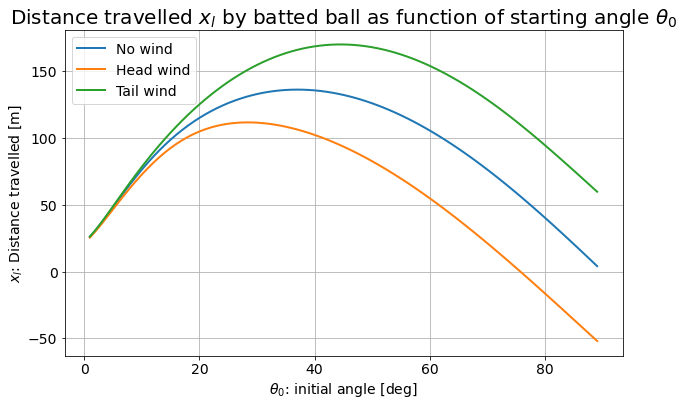

Optimal batting angle, no wind: 37.00°
This results in a distance of: 136.27 m 

Optimal batting angle, head wind: 28.00°
This results in a distance of: 111.72 m 

Optimal batting angle, tail wind: 44.00°
This results in a distance of: 170.07 m 



In [10]:
plt.figure(0)
plt.plot(np.degrees(theta), xl_array_nowind, label="No wind")
plt.plot(np.degrees(theta), xl_array_head, label="Head wind")
plt.plot(np.degrees(theta), xl_array_tail, label="Tail wind")
plt.xlabel(r"$\theta_{0}$: initial angle [deg]")
plt.ylabel(r"$x_l$: Distance travelled [m]")
plt.title(r"Distance travelled $x_l$ by batted ball as function of starting angle $\theta_0$", fontsize=20)
plt.legend()
plt.show()

print(f"Optimal batting angle, no wind: {'{:.2f}'.format(optimal_nowind)}°")
print(f"This results in a distance of: {'{:.2f}'.format(max_nowind)} m \n")
print(f"Optimal batting angle, head wind: {'{:.2f}'.format(optimal_head)}°")
print(f"This results in a distance of: {'{:.2f}'.format(max_head)} m \n")
print(f"Optimal batting angle, tail wind: {'{:.2f}'.format(optimal_tail)}°")
print(f"This results in a distance of: {'{:.2f}'.format(max_tail)} m \n")

Something interesting, but perhaps not shocking, happens when we take wind conditions into account. We can clearly see that the optimal batting angle decreases with headwind, and increases with tailwind. If we take a look at the graph of distance travelled as a function of initial angle, we see that for some large angles in the headwind scenario, the ball ends up behind the batter. The headwind is strong enough so that it gives the batter a run for his money, and if he hit the ball sufficiently high, it will push so hard that the ball eventually turns around. Thus it is intuitive that the ball should be hit with a smaller initial angle when there is headwind, to give the resistive force less time to accelerate the ball backwards and to give the ball more speed forward. With tailwind, however, players can hit the ball farther, due to the fact that the wind "helps" the ball in the air, and the optimal angle is therefore a combination of assistance from the wind and forward velocity. A high hit in this condition would give the wind more time to push, but decrease forward motion - and vice versa.

And now over to where the money is at. What draws the crowd to their seats. The well known home run. Given optimal batting angle in each wind condition, how hard must our batter hit the ball for it to go beyond the playing field and into the crowd? This distance is about $168$ m, and we will do calculations with increasing exit velocity until a home run is achieved for each wind type.

In [11]:
v0_vals = np.arange(40, 80, 1)            # Array of various initial speeds, [m/s]

# ZERO WIND
theta0 = np.radians(optimal_nowind)       # Setting initial angle to optimal batting angle, no wind, [rad]
xl_home = 0                               # Defining variable which will disclose if home run is achieved, [m]
n = 0                                     # Counting variable

vwind = np.array([vwind_zero, 0, 0])      # Array with velocity of wind in each direction [x, y, z]

# Run simulations with optimal batting angle and increasing initial speed until home run is achieved
while xl_home < 168:
    vx0 = v0_vals[n]*np.cos(theta0)        # x-component of initial velocity, [m/s]
    vy0 = v0_vals[n]*np.sin(theta0)        # y-component of initial velocity, [m/s]
    vz0 = 0                                # z-component of initial velocity, [m/s]
    v0_array = np.array([vx0, vy0, vz0])   # Array with initial velocities in each direction [x, y, z]
    
    # Run simulation
    r_home, v_home, t_home, rl_home = ode_solver(EOM_1a, omega, r0, v0_array, 0)
    
    xl_home = rl_home[0]     # Updating variable for distance travelled
    
    n += 1                   # Increment counter

print(f"Speed of ball for homerun, no wind: {'{:.1f}'.format(v0_vals[n])} m/s")

# HEADWIND

theta0 = np.radians(optimal_head)         # Setting initial angle to optimal batting angle, headwind, [rad]
xl_home = 0                               # Defining variable which will disclose if home run is achieved, [m]
n = 0                                     # Counting variable

vwind = np.array([vwind_head, 0, 0])      # Array with velocity of wind in each direction [x, y, z]

# Run simulations with optimal batting angle and increasing initial speed until home run is achieved
while xl_home < 168:
    vx0 = v0_vals[n]*np.cos(theta0)        # x-component of initial velocity, [m/s]
    vy0 = v0_vals[n]*np.sin(theta0)        # y-component of initial velocity, [m/s]
    vz0 = 0                                # z-component of initial velocity, [m/s]
    v0_array = np.array([vx0, vy0, vz0])   # Array with initial velocities in each direction [x, y, z]
    
    # Run simulation
    r_home, v_home, t_home, rl_home = ode_solver(EOM_1a, omega, r0, v0_array, 0)
    
    xl_home = rl_home[0]     # Updating variable for distance travelled
    
    # Increment counter
    n += 1

print(f"Speed of ball for homerun, headwind: {'{:.1f}'.format(v0_vals[n])} m/s")

# TAILWIND

theta0 = np.radians(optimal_tail)         # Setting initial angle to optimal batting angle, tailwind, [rad]
xl_home = 0                               # Defining variable which will disclose if home run is achieved, [m]
n = 0                                     # Counting variable

vwind = np.array([vwind_tail, 0, 0])      # Array with velocity of wind in each direction [x, y, z]

# Run simulations with optimal batting angle and increasing initial speed until home run is achieved
while xl_home < 168:
    vx0 = v0_vals[n]*np.cos(theta0)        # x-component of initial velocity, [m/s]
    vy0 = v0_vals[n]*np.sin(theta0)        # y-component of initial velocity, [m/s]
    vz0 = 0                                # z-component of initial velocity, [m/s]
    v0_array = np.array([vx0, vy0, vz0])   # Array with initial velocities in each direction [x, y, z]
    
    # Run simulation
    r_home, v_home, t_home, rl_home = ode_solver(EOM_1a, omega, r0, v0_array, 0)
    
    xl_home = rl_home[0]     # Updating variable for distance travelled
    
    # Increment counter
    n += 1

print(f"Exit speed of ball for homerun, tailwind: {'{:.1f}'.format(v0_vals[n])} m/s")

Speed of ball for homerun, no wind: 59.0 m/s
Speed of ball for homerun, headwind: 70.0 m/s
Exit speed of ball for homerun, tailwind: 51.0 m/s


As expected, the required exit speed of a baseball from the bat differs depending on which way the wind blows. Headwind blowing against the direction of the ball increases the necessary speed, and opposite for tailwind coming from behind.

### Curve ball

Anyone who has seen a game of baseball knows that the pitch can be just as spectacular as the hit itself. The pitcher standing directly opposed to the batter can throw the ball at unbelievable speeds, challenging even the best players in the industry. What makes some of the balls more difficult to strike is the thrower's secret weapon - a curve ball. Such a throw is achieved when the ball rotates along its axis, giving rise to a force perpendicular to the center of mass velocity. This force, called Magnus force, originates from the fact that the velocity, with respect to the wind, differs depending on which side of the ball you look at. The side with highest velocity gives rise to the largest drag, and thereby creating a net force acting perpendicular to the direction of the ball. Baseball players know this fact by heart, and pitchers perfectly utilizes this Magnus force to mislead the opposing players.

To calculate exactly how such a spinning ball would behave, we will now look at the motion in three dimensions, and modify the previous EOM by taking the Magnus force into account. As of now, we will only look at a horizontal throw with spinning in the $y$-direction, and the the Magnus force is therefore $F_{M} = S_{0}\omega v_{x}$. Drag forces are negligible in $y$- and $z$-direction, and we assume the angular frequency $\omega$, and $S_{0}$, to be constants. Also, there is no longer wind. The resulting EOM becomes:

$$
\frac{d}{dt}\begin{bmatrix}\ x \\ y \\ z \\ v_{x} \\ v_{y} \\ v_{z} \\ \beta \end{bmatrix} = \begin{bmatrix}\ v_x \\ v_y \\ v_z \\ -\frac{B_2vv_x}{m} \\ -g \\ -\frac{S_0\omega v_x}{m} \\ 0 \end{bmatrix}
$$

Even though the orientation of the ball $\beta$ changes, the orientation itself does not impact our solution. We therefore set $\dot{\beta} = 0$.

In [12]:
def EOM_1b(t, w):
    """
    INPUT:
    t:     float,     Current time in calculations
    w:     1D array,  Array with quantities of interest, corresponds to left side of 1st order representation of equations of motion
    ---
    Returns a 1D array with the right hand side of the 1st order representation of equations of motion
    """
    return np.array([w[3],
                     w[4],
                     w[5],
                     -B2(w[3:-1])/m * norm(w[3:-1])*w[3],
                     -g,
                     -(S0*w[3]*ang_freq),
                     0])

In [13]:
S0 = (4.1e-4)                     # Drag force over entire surface, constant
v0_1b = np.array([35, 0, 0])      # Initial velocity, m/s
r0_1b = np.array([0, 1.8, 0])     # Initial position, m
theta0 = 0                        # Initial angle, rad - Kanskje ikke nødvendig

# NO SPIN
ang_freq = 0
r_nospin, v_nospin, t_nospin, rl_nospin = ode_solver(EOM_1b, omega, r0_1b, v0_1b, 0)

# SPIN
ang_freq = 30*2*np.pi             # Angular frequency, constant, rad/s
r_spin, v_spin, t_spin, rl_spin = ode_solver(EOM_1b, omega, r0_1b, v0_1b, 0)

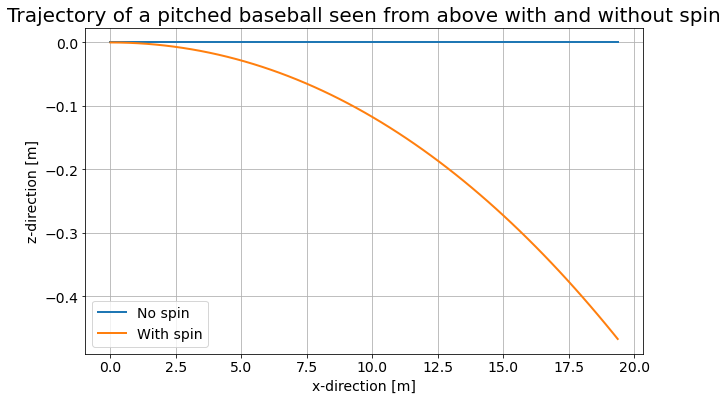

With spin on the ball, the trajectory is deflected 0.47 m in negative z-direction


In [14]:
plt.figure(2)
plt.plot(r_nospin[:, 0], r_nospin[:, 2], label="No spin")
plt.plot(r_spin[:, 0], r_spin[:, 2], label="With spin")
plt.title("Trajectory of a pitched baseball seen from above with and without spin", fontsize=20)
plt.xlabel("x-direction [m]")
plt.ylabel("z-direction [m]")
plt.legend()
plt.show()

print(f"With spin on the ball, the trajectory is deflected {'{:.2f}'.format(abs(rl_spin[2]))} m in negative z-direction")

The plot above shows two completely different pitches, one with no spinning whatsoever, and one where the ball spins with $30$ rev/s along its own axis. The results are noticeable. The spinning ball gets deflected just below half a meter to the side. A professional pitcher can most definitely exploit this to his advantage.

### Knuckleball

The most dangerous of all pitches is called a knuckleball. It is surely a self confidence-destroyer for the opposing team, but is challenging for the pitcher to control as well. Even the catcher will have to prove his worth, and the umpire himself will have a hard time calling the correct decision. A knuckleball can be chaotic and disorienting for every person on the field, and that is what makes it such a dangerous pitch.

The key factor in explaining the motion of a knuckleball is its unpredictability. Opposed to what one might think, spin is not the culprit for this motion, but rather the lack of it. A knuckleball is thrown with very little or no spin at all, and the red stitches along the surface gives the ball a unique texture with a combination of roughness on some parts, and smoothness on other. This again leads to an imbalance of drag forces making the ball curve to one side. In addition, when the ball slowly rotates around itself, this force will change direction as well, causing the irregular behavior. No pitch is exactly the same, and each knuckleball is therefore also one of a kind.

To calculate the trajectory of such a ball, we  report to empirical data based on wind tunnel experiments. We will therefore express the lateral force on the ball as 

$$\frac{F_{lateral}}{mg} = 0.5[\sin(4θ) − 0.25 \sin(8θ) + 0.08 \sin(12θ) − 0.025 \sin(16θ)]$$,

and again modify the EOM. We express the lateral force as a function `Flateral()` in order to calculate it as $\beta$ changes thoughout the pitch. Since $F_{lateral}$ acts perpendicular to the velocity of the ball, the $z$-component of the lateral force is given by:

$$
F_{\text{lateral, z}} = F_{\text{lateral}}\frac{v_x}{v}
$$

We will look at how unique each knuckleball is by varying initial angular orientation, angular frequency and initial velocity. We include the above lateral force and the angular orientation $\beta$ in our EOM as such, still neglecting drag in $y$- and $z$-direction:

$$
\frac{d}{dt}\begin{bmatrix}\ x \\ y \\ z \\ v_{x} \\ v_{y} \\ v_{z} \\ \beta \end{bmatrix} = \begin{bmatrix}\ v_x \\ v_y \\ 0 \\ -\frac{B_2vv_x}{m} \\ -g \\ -\frac{S_0\omega v_x - F_{lateral}(\beta)\frac{v_x}{v}}{m} \\ \omega \end{bmatrix}
$$

In [15]:
def Flateral(beta):
    """
    INPUT:
    beta:     float,     Angular orientation of ball
    ---
    Returns the lateral force on the ball due to roughness on the surface as a function of the
    angular orientation of the ball. Acts perpendicular to the center of mass velocity.
    """
    return m*g*0.5*(np.sin(4*beta) - 0.25*np.sin(8*beta) + 0.08*np.sin(12*beta) - 0.025*np.sin(16*beta))

# Equations of motion as a function of w
def EOM_1c(t, w):
    """
    INPUT:
    t:     float,     Current time in calculations
    w:     1D array,  Array with quantities of interest, corresponds to left side of 1st order representation of equations of motion
    ---
    Returns a 1D array with the right hand side of the 1st order representation of equations of motion
    """
    return np.array([w[3],
                     w[4],
                     w[5],
                     -(B2(w[3:-1])*norm(w[3:-1])*w[3])/m,
                     -g,
                     -S0*ang_freq*w[3] + Flateral(w[-1])*(w[3]/norm(w[3:-1]))/m,
                     ang_freq])


In [16]:
N1 = 4         # Number of initial beta values
N2 = 4         # Number of angular frequency values
N3 = 4         # Number of initial velocity vectors

r0_1c = np.array([0, 1.8, 0])             # Initial position
vwind = np.zeros(3)                       # Set wind to zero

beta0_1c = np.linspace(0, 3, N1)          # Array of initial angles beta
ang_freq0_1c = np.linspace(6, 9, N2)      # Array of angular frequencies

# Construct array with initial velocity vectors
v0_1c = np.zeros((N3, 3))
v0_1c[:, 0] = np.linspace(35, 45, N3)

plot_arr = []                             # Initialize list for storing position data from simulations

# Run simulations for all combinations of initial parameters beta, angular frequency and velocity
for i, beta in enumerate(beta0_1c):
    for j, ang_freq in enumerate(ang_freq0_1c):
        for k, v0 in enumerate(v0_1c):
            r_knuckle, v_knuckle, t_knuckle, rl_knuckle = ode_solver(EOM_1c, omega, r0, v0, beta)
            plot_arr.append(r_knuckle)    # Store position data from simulation

plot_arr = np.array(plot_arr)             # Change list into array

Text(0, 0.5, 'z-direction [m]')

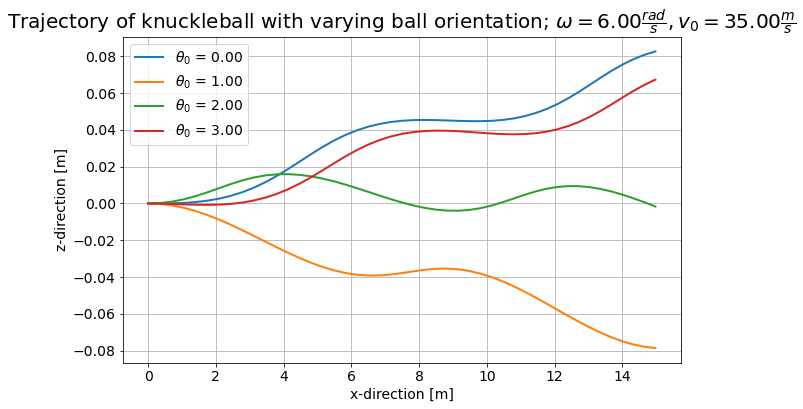

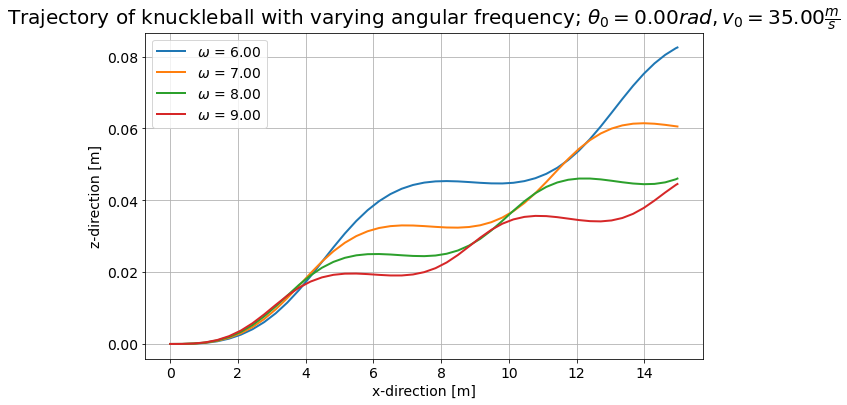

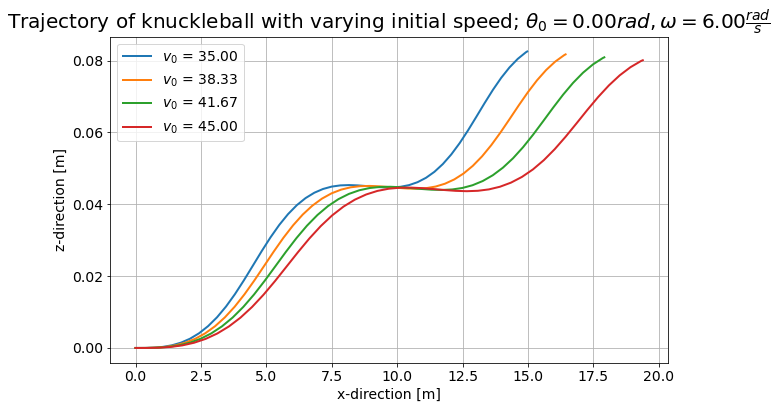

In [17]:
plt.figure(3)
plt.plot(plot_arr[::N2*N3, :, 0].T, plot_arr[::N2*N3, :, 2].T)                     #Varying beta0 with first values of ang_freq and v0
plt.legend([r"$\theta_0$ = "+'{:.2f}'.format(beta) for beta in beta0_1c])
plt.title(fr"Trajectory of knuckleball with varying ball orientation; $\omega = {'{:.2f}'.format(ang_freq0_1c[0])}\frac{{rad}}{{s}}, v_0 = {'{:.2f}'.format(norm(v0_1c[0]))}\frac{{m}}{{s}}$", fontsize=20)
plt.xlabel("x-direction [m]")
plt.ylabel("z-direction [m]")

plt.figure(4)
plt.plot(plot_arr[:N2*N3:N3, :, 0].T, plot_arr[:N2*N3:N3, :, 2].T)                     #Varying angular frequency with first values of beta0 and v0
plt.legend([r"$\omega$ = "+'{:.2f}'.format(ang_freq) for ang_freq in ang_freq0_1c])
plt.title(fr"Trajectory of knuckleball with varying angular frequency; $\theta_0 = {'{:.2f}'.format(beta0_1c[0])}rad, v_0 = {'{:.2f}'.format(norm(v0_1c[0]))}\frac{{m}}{{s}}$", fontsize=20)
plt.xlabel("x-direction [m]")
plt.ylabel("z-direction [m]")

plt.figure(5)
plt.plot(plot_arr[:N3, :, 0].T, plot_arr[:N3, :, 2].T)                     #Varying v0 with first values of ang_freq and beta0
plt.legend([r"$v_0$ = "+'{:.2f}'.format(v0) for v0 in norm(v0_1c, axis=1)])
plt.title(fr"Trajectory of knuckleball with varying initial speed; $\theta_0 = {'{:.2f}'.format(beta0_1c[0])}rad, \omega = {'{:.2f}'.format(ang_freq0_1c[0])}\frac{{rad}}{{s}}$", fontsize=20)
plt.xlabel("x-direction [m]")
plt.ylabel("z-direction [m]")

The plots above show trajectories with varying parameters; initial angular orientation $\beta$, angular frequency $\omega$ and initial speed $v_0$. For each plot, one parameter varies while the other two remain fixed.

The first remark to make is that the trajectories follow a somewhat oscillating path. This oscillation is due to the fact that the spin of the ball changes the strength and direction in which the lateral force on the ball acts. When the ball has spun a conciderable amount, the lateral force will accelerate the ball in eg. negative $z$-direction as opposed to a potential earlier acceleration in positive $z$-direction. This effect due to the angular frequency is emphasized by the fact that greater angular frequencies result in faster oscillations in our second plot.

Secondly, almost every trajectory tends to a specific direction. Two factors can be thought to contribute to this fact: the Magnus force and an imbalance in contributions from the lateral force in the two $z$-directions. From our simulations, a reasonable conclusion to draw is that the imbalance in the lateral force is the main contributor to this phenomenon. Since the Magnus force is proportional to the angular frequency and the speed of the ball, one would expect the total deflection in the direction the Magnus force acts to increase with increasing angular frequency and initial speed. Since the Magnus force and the lateral force act in different directions at the start, given positive spin in $y$-direction and positive $\beta$, a greater angular frequency should mean that the Magnus force counteracts the lateral force. This is seen in our second plot, but the deflection is still influenced the most by the lateral force acting in positive $z$-direction initially. This indicates that the Magnus force is small compared to the lateral force in our simulations, which can be explained by the fact that the ball is spinning slowly, yielding a small Magnus force. An explanation to the phenomenon would then be that since the ball experiences drag, slowing its velocity in the $x$-direction, the lateral force in the $z$-direction has been reduced when the ball has spun to an orientation which produces a lateral force in the opposite direction to what was initially seen. This would mean that the force accelerating the ball in the new direction will not be as large as the initial force. During the pitch, this imbalance will make the ball travel in a preferred direction. This is best illustrated by the graph of the ball with the green trajectory in the first plot; $\beta = 2.00$ with fixed values for $\omega \text{ and }v_0$. The net trajectory is almost exclusively straight, but since the ball is initially deflected in positive $z$-direction, the contributions of the lateral force in negative $z$-direction are smaller. This would result in a marginal net deflection in positive $z$-direction. In our plot, the final deflection is negative since the pitch ends in a phase near a negative maximum. Had the pitch gone on for longer, one would expect such a marginal positive deflection, indicated by the larger positive maxima relative to the negative one.

Finally, the aim of a knuckle ball is to fool the batter by pitching a ball with an unpredictable trajectory. From the three plots, it is apparent that the initial angular orientation $\beta$ yields the seemingly most random results compared to the other two parameters. Increasing initial speed produces does little to change the overall trajectory. Increasing angular frequency makes the oscillations faster and changes the net direction of the trajectory to some degree. In contrast, varying the initial angular orientation even by one radian can in some cases change the deflection of the pitch by around $16$ cm. The trajectories might be similar in overall shape, but the resulting deflection changes drastically due to $\beta$ varying. These large variations in deflection occur due to the imbalance of lateral force discussed earlier and are impacted the most by $\beta$ because what phase the lateral force is in at the start of the pitch greatly impacts the overall trajectory of the ball; as the lateral force is the greatest contributor to deflection at such low angular frequencies. With a rapid displacement, especially close to home base, the batter might not have time enough to react before the ball finds its way into the catchers firm grip. And if a pitcher were to throw a knuckleball twice in a row, it would much rather be in his favor to vary the initial angular orientation.

## Golf

### Backspin

Leaving the baseball field, and entering the golf course, we will now turn our attention to the dimpled golf ball. We will calculate the same type of projectile motion, but taking into account the different structure of the surface. A golf ball is filled with dimples all around, and this will reduce the drag force acting upon it. We shall use the same principle as before, but we have to modify the EOM once again. Firstly we will assume a shot straight down the $x$-axis, and therefore no horizontal $z$-component yet. The equations are therefore given as 

$$
\frac{dv_{x}}{dt} = -\frac{F_{drag,x}}{m} -\frac{S_{0}v_{y}\omega}{m}
$$

$$
\frac{dv_{y}}{dt} = -\frac{F_{drag,y}}{m} +\frac{S_{0}v_{x}\omega}{m} - g
$$

For now we will assume the ball is hit with perfect backspin with the spin axis in $z$-direction, perpendicular to the other axis. The drag force is given as

$$
F_{drag} = -C \rho Av^2
$$

where $\rho$ and $A$ is the air density and profile area of the ball respectively, $v$ the velocity, and $C$ a drag coefficient. The difference between the baseball scenario and this golf ball, is that this coefficient drops as the ball reaches a certain velocity. Also, as mentioned before, the dimples on the surface of a golf ball reduces drag. We will compare trajectories of dimpled and smooth balls, and will therefore also define $C$ for the smooth ball case. It is defined as such:

$$
C = \begin{cases}
		\frac{1}{2} 	& \text{, ball is smooth} \\
        \frac{1}{2} 	& \text{, } v<14 \text{ m/s} \\
        \frac{7}{v} 	& \text{, } v\geq 14 \text{ m/s}
        \end{cases}
$$

We will also assume the angular frequence $\omega$ to be constant, such that the Magnus force the ball experiences only depends on its speed. We will also use the approximation $\frac{S_0\omega}{m}\approx 0.25\text{s}^{-1}$. Our EOMs then become:

$$
\frac{d}{dt}\begin{bmatrix}\ x \\ y \\ z \\ v_{x} \\ v_{y} \\ v_{z} \\ \beta \end{bmatrix} = \begin{bmatrix}\ v_x \\ v_y \\ 0 \\ \frac{F_{\text{drag}}}{m}\frac{v_x}{v}-\frac{S_0\omega}{m} v_y \\ \frac{F_{\text{drag}}}{m}\frac{v_y}{v} + \frac{S_0\omega}{m} v_x - g \\ 0 \\ 0 \end{bmatrix}
$$


In [18]:
def EOM_2a(t, w, smooth = False):
    """
    INPUT:
    t:         float,     Current time in calculations
    w:         1D array,  Array with quantities of interest, corresponds to left side of 1st order representation of equations of motion
    smooth:    bool,      Indicates if a smooth ball without dimples is used. Standard is False.
    ---
    Returns a 1D array with the right hand side of the 1st order representation of equations of motion
    """
    
    # Set drag coefficient C according to criteria
    if smooth is True:
        C = 1/2
    elif norm(w[3:-1]) < 14:
        C = 1/2
    elif norm(w[3:-1]) >= 14:
        C = 7/norm(w[3:-1])

    return np.array([w[3],
                     w[4],
                     0,
                     - (C*rho*np.pi*r_golf**2*norm(w[3:-1])**2/m_golf * (w[3]/norm(w[3:-1]))) - Fmagnus*w[4],
                     - (C*rho*np.pi*r_golf**2*norm(w[3:-1])**2/m_golf * (w[4]/norm(w[3:-1]))) + Fmagnus*w[3] - g,
                     0,
                     0], dtype="float64")

# Define a function for smooth ball
EOM_smooth_2a = lambda t, w: EOM_2a(t, w, True)

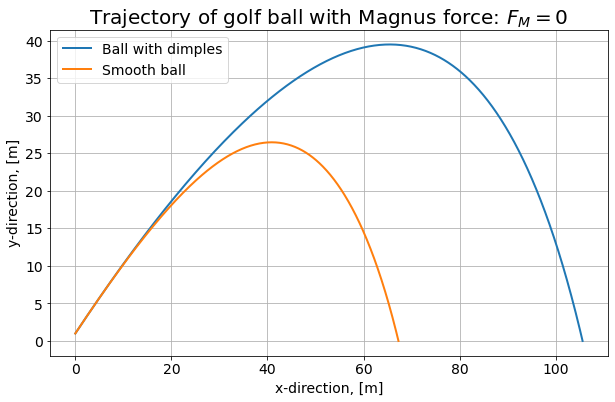

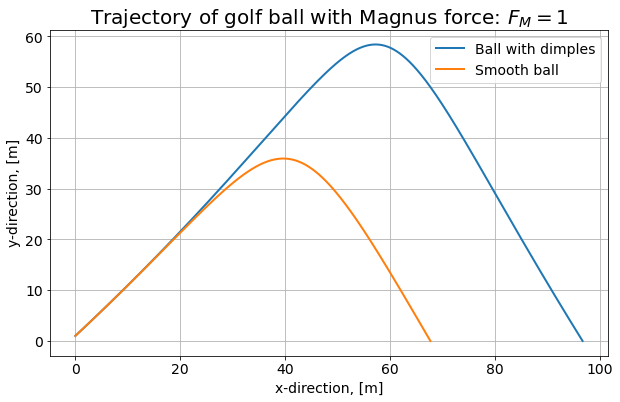

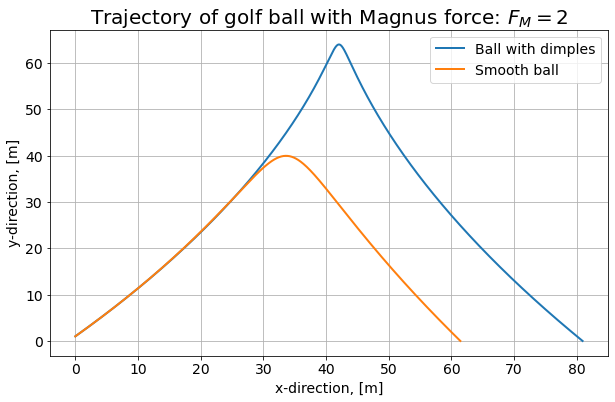

In [19]:
r0_2a = np.array([0, 0.1, 0])                             # Initial position

theta_2a = np.radians(9)                                  # Initial angle of shot relative to horisontal

v0_2a = 70                                                # Initial speed of ball
v0x_2a = v0_2a*np.cos(theta_2a)                           # x-component of initial velocity
v0y_2a = v0_2a*np.sin(theta_2a)                           # y-component of initial velocity
v0_2a_array = np.array([v0x_2a, v0y_2a, 0])               # Initial velocity vector

Fmagnus_A = 0.25                                          # Approximated magnus force = S0 * ang_freq / m, [N]
Fmagnus_B = Fmagnus_A*1.5                                 # Approximated magnus force for 50% more backspin, [N]
Fmagnus_array = np.array([0, Fmagnus_A, Fmagnus_B])       # Array for Magnus force, [N]
r_golf = 0.5*42.67e-3                                     # Radius of golf ball, [m]
rho = 1.225                                               # Air density, [kg/m^3]
m_golf = 45.93e-3                                         # Mass of golf ball, [kg]


# Run simulations and plot trajectories of smooth and dimpled ball for the three different spins
for i, Fmagnus in enumerate(Fmagnus_array):
    # Run simulation for both dimpled and smooth ball
    r_2a, v_2a, time_2a, rl_2a = ode_solver(EOM_2a, omega, r0, v0_array, 0)
    r_smooth_2a, v_smooth_2a, time_smooth_2a, rl_smooth_2a = ode_solver(EOM_smooth_2a, omega, r0, v0_array, 0)
    
    # Plot the two trajectories in the same plot
    plt.figure(6+i)
    plt.title(fr"Trajectory of golf ball with Magnus force: $F_M = {i}$", fontsize=20)
    plt.xlabel("x-direction, [m]")
    plt.ylabel("y-direction, [m]")
    plt.plot(r_2a[:, 0], r_2a[:,1], label="Ball with dimples")
    plt.plot(r_smooth_2a[:, 0], r_smooth_2a[:, 1], label="Smooth ball")
    plt.legend()
    #plt.legend([fr"$F_{{Magnus}}$ = {i}" for i in Fmagnus_array])



We can see two completely different trajectories when comparing the smooth ball to a ball with dimples. The dimpled ball travels farther, achieves a higher maximum, and reaches this point later than the smooth ball. They seem to stick close together at the beginning, but the the smooth starts falling downward when the dimpled one still continues towards the sky. This phenomena illustrates how crucial it is for the ball to have the correct surface structure. A dimpled ball without backspin can travel as much as $40$ m farther compared to its rival.

Another interesting result occurs as we increase the backspin, and thereby the Magnus force. As this force increases, the projectile motion is narrower, reaches higher, and has a sharper peak at the top. However, this type of motion with a sharper apex actually decreases the length of the shot, and we can see here that a Magnus force of $F_{M} = 0.375$ N shortens the length by about $20$ m for the dimpled ball. This reduction is not as prominent as for the smooth ball, but we can see that it also loses a couple of meters lengthwise. Since spin makes the ball reach higher, one might expect the shot to travel farther. Even if this is true, it is apparent that the Magnus force horizontally acts in negative $x$-direction when the ball has upward speed, decelerating the ball. When the ball starts falling the spin will yield positive horizontal acceleration, but since there is drag in the vertical direction there will be more kinetic energy contributing to the decelerating phase than for the acceleration. The result is this shortening in the length of the shots.

### Slicing and hooking

A worthy adversary for any recreational golfer is the shot called a slice. The most extreme slices can be club-breakers for sure, and can be a pain to get rid of. The opposite of a slice is called a hook, and this can be just as frustrating. These types of shots are created when the ball gets an additional side spin. Remembering the effects of the Magnus force, a spin can result in a trajectory deviating far off the intended path. Where we saw the pitched baseball only deflect half a meter, a side spin in golf would make the ball stray far away from its destination.

To calculate how far off a side-spinning golf ball could stray, we will create the EOM in all three dimensions, and adding the fact that $F_{M} = S_{0} \vec{\omega_0} \times \vec{v}$. We have denoted the angular frequency vector as $\omega_0$ to distinguish between angular frequency and the vector with quantities of interest $\vec{\omega}$. Since the spin will have the same magnitude in both $x$- and $z$-direction, the vector product will be

$$
\frac{\vec{F}_M}{m} = \frac{S_0\omega}{m}\left[- v_y, v_x - v_z, v_y\right]
$$

In order to decompose the drag force, we define $\theta = \arcsin{\left(\frac{v_y}{v}\right)}$ and $\phi = \arctan{\left(\frac{v_z}{v_x}\right)}$ where $\theta$ is the angle between the velocity vector and the $y$-axis, and $\phi$ is the angle between the $xz$-projection of the velocity and the $z$-axis. Decomposition of the the drag force is therefore

$$
\vec{F}_{\text{drag}} = F_{\text{drag}}\left[\cos{\theta}\cos{\phi}, \sin{\theta}, \cos{\theta}\sin{\phi}\right]
$$

Our resulting EOMs become:

$$
\frac{d}{dt}\begin{bmatrix}\ x \\ y \\ z \\ v_{x} \\ v_{y} \\ v_{z} \\ \beta \end{bmatrix} = \begin{bmatrix}\ v_x \\ v_y \\ v_z \\ \frac{F_{\text{drag}}}{m}\cos{\theta}\cos{\phi}-\frac{S_0\omega}{m} v_y \\ \frac{F_{\text{drag}}}{m} \sin{\theta} + \frac{S_0\omega}{m} \left(v_x - v_z\right) - g \\ \frac{F_{\text{drag}}}{m}\cos{\theta}\sin{\phi} + \frac{S_0\omega}{m} v_y \\ 0 \end{bmatrix}
$$

In [20]:
def EOM_2b(t, w, smooth = False):
    """
    INPUT:
    t:         float,     Current time in calculations
    w:         1D array,  Array with quantities of interest, corresponds to left side of 1st order representation of equations of motion
    smooth:    bool,      Indicates if a smooth ball without dimples is used. Standard is False.
    ---
    Returns a 1D array with the right hand side of the 1st order representation of equations of motion
    """
    
    # Set drag coefficient C according to criteria
    if smooth is True:
        C = 1/2
    elif norm(w[3:-1]) < 14:
        C = 1/2
    elif norm(w[3:-1]) >= 14:
        C = 7/norm(w[3:-1])
    
    # Calculate angles for direction of motion to decompose the drag force
    theta = np.arcsin(w[4]/norm(w[3:-1]))
    phi = np.arctan(w[5]/w[3])
    
    return np.array([w[3],
                     w[4],
                     w[5],
                     - (C*rho*np.pi*r_golf**2*norm(w[3:-1])**2/m_golf * np.cos(theta)*np.cos(phi)) - Fmagnus*w[4],
                     - (C*rho*np.pi*r_golf**2*norm(w[3:-1])**2/m_golf * np.sin(theta)) + Fmagnus*(w[3] - w[5]) - g,
                     - (C*rho*np.pi*r_golf**2*norm(w[3:-1])**2/m_golf * np.cos(theta)*np.sin(phi)) + Fmagnus*w[4],
                     0])

# Define a function for smooth ball
EOM_smooth_2b = lambda t, w: EOM_2b(t, w, True)

In [21]:
r0_2b = np.array([0, 0, 0])                             # Initial position

theta_2b = np.radians(9)                                # Initial angle of shot with respect to horizontal

v0_2b = 70                                              # Initial speed
v0x_2b = v0_2b*np.cos(theta_2b)                         # x-component of initial velocity
v0y_2b = v0_2b*np.sin(theta_2b)                         # y-component of initial velocity
v0_2b_array = np.array([v0x_2b, v0y_2b, 0])             # Array for initial velocity

Fmagnus_A = 0.25                                        # Approximated Magnus force = S0 * ang_freq / m, [N]
Fmagnus_B = Fmagnus_A*1.5                               # Approximated Magnus force for 50% more backspin, [N]
Fmagnus_array = np.array([0, Fmagnus_A, Fmagnus_B])     # Array for Magnus force, [N]
r_golf = 0.5*42.67e-3                                   # Radius of golf ball, [m]
rho = 1.225                                             # Air density, [kg/m^3]
m_golf = 45.93e-3                                       # Mass of golf ball, [kg]

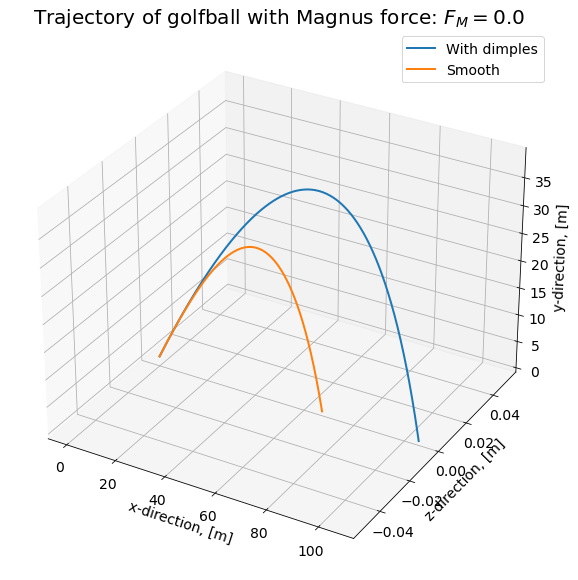

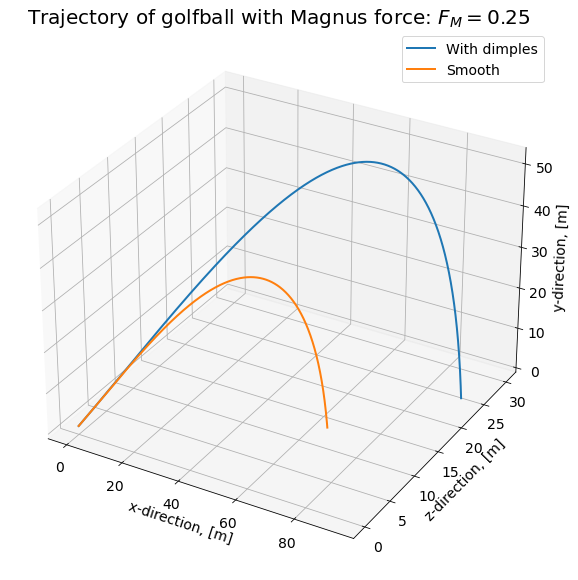

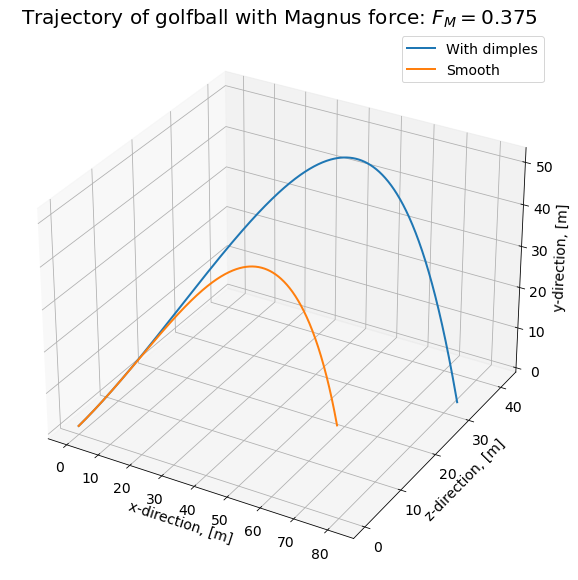

In [22]:
# Run simulations and plot trajectories for smooth and dimpled ball for the three different spins
for Fmagnus in Fmagnus_array:
    
    # Run simulations for dimpled and smooth ball
    r_2b, v_2b, time_2b, rl_2b = ode_solver(EOM_2b, omega, r0, v0_array, 0)
    r_smooth_2b, v_smooth_2b, time_smooth_2b, rl_smooth_2b = ode_solver(EOM_smooth_2b, omega, r0, v0_array, 0)
    
    # Plot trajectories in 3D plots, dimpled and smooth in same plot
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection='3d')

    ax.plot3D(r_2b[:, 0], r_2b[:, 2], r_2b[:, 1], label="With dimples")
    ax.plot3D(r_smooth_2b[:, 0], r_smooth_2b[:, 2], r_smooth_2b[:, 1], label="Smooth")
    ax.set_xlabel("x-direction, [m]")
    ax.set_ylabel("z-direction, [m]")
    ax.set_zlabel("y-direction, [m]")
    ax.set_title(fr"Trajectory of golfball with Magnus force: $F_M = {Fmagnus}$", fontsize=20)
    ax.legend()

Here are three different types of shots with a smooth and a dimpled ball. As the Magnus force is increasing, we get the same behavior as before where the peak is sharper and trajectory narrower. The effects of the drag coefficient is also as previously, where the smooth ball travels a shorter distance since it experiences a larger drag force.

What is different here is the effects of the side spin. It contributes to a motion in the $z$-direction, even if the initial velocity was zero in this direction. This occurs because the Magnus force in $z$-direction depends on vertical velocity and the spin in $x$-direction. Important to notice is that the acceleration in $z$-direction seems to change sign after the apex of the shot. This happens because the vertical velocity changes sign, meaning the Magnus force and therefore the acceleration also changes sign. The ball does however not return to $z=0$. This is because, once again, the drag slows the ball down meaning forces that depend on velocity will be weaker later in the shot relative to the start.

A professional golfer would naturally bear this in mind and tailor the shot to travel exactly where he intends to. Maybe if he even glimpsed at our calculations, he might be able to make the celebrated hole-in-one? 

## Final remarks

In this computational assignment we have explored the physics of both baseball and golf. We have used numerical methods to solve the equations of motion for a baseball and a golf ball. During this process we have studied how trajectories of baseballs and golf balls depend on initial speeds, spin in various directions, drag and the surface attributes of the balls themselves. With this, both Tiger Woods and the New York Yankees can rest assured that the physics of their sports has been somewhat de-mystified.